In [2]:
##imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

##will need        scipy.integrate.odeint

In [3]:
##this block is for general info regarding how the project is to proceed

###the analysis and comments appear as markdown text below the relevant blocks

##1 means the block is used by both the nonlinear and linear portions
##2 means that the block is setting up nonlinear function definitions and dependencies
##3 is the blocks running the nonlinear simulations
##4 is setting up the linear functions definitions and dependencies
##5 is running linear simulations
##6 is for plotting


# Part 1 Set up the functions for the linearized and nonlinear ODEs

In [22]:
##1

##---set up all constants---##
I_m = 700
k = 100
m = 500
g = 9.81
W = 300
r0 = 3
del_c = 0.05
del_R = 5
R_0 = 5
L = 0.4

##use this portion to test the equations
x_bar = 0
r_bar = np.sqrt((x_bar*del_c/np.pi)+(r0**2))
v_bar = r_bar*g*(m-W)*(R_0+del_R)/k
x_dot_bar=0
i_bar = (m-W)*g*r_bar/k
divisor = m*r_bar-(I_m/r_bar)
print(divisor)
print(i_bar)
print(v_bar)
print((v_bar/L)-((R_0+del_R)*i_bar/L))


1266.6666666666667
58.86
588.6
0.0


In [5]:
t = np.linspace(0, 15, 1500)

In [6]:
##1

##---set up a function to return the trim variables---#
def trim(x_bar, m, g, W, R_0, del_R, del_c, r_0, k):
    r_bar = np.sqrt((x_bar*del_c/np.pi)+r0**2)
    v_bar = r_bar*g*(m-W)*(R_0+del_R)/k
    x_dot_bar=0
    i_bar = (m-W)*g*r_bar/k
    
    print("r_bar=", r_bar)
    print("x_dot_bar=", x_dot_bar)
    print("i_bar=", i_bar)
    print("v_bar=", v_bar)
    return x_dot_bar, i_bar, r_bar, v_bar;
    

In [25]:
##2

##---Nonlinear ODEs---##
def nonlin_odes(x_vec, t):
    #constants set internally to keep things in the ode, reduce functional dependency
    I_m = 700
    k = 100
    m = 500
    g = 9.81
    W = 300
    r0 = 3
    del_c = 0.05
    del_R = 5
    R_0 = 5
    L = 0.4
    tauR=3
    
    #assign each ODE to a vector element
    x = x_vec[0]
    x_dot = x_vec[1]
    i = x_vec[2]
    r = x_vec[3]
    divisor = (m*r)-(I_m/r)
    
    #define the doublet 
    ###let the doublet be defined with magnitude 20 and period 5s
    c = 20
    if t<5:
        v_bar_c = v_bar+c
    elif t>5:
        v_bar_c = v_bar-c
    if t>10:
        v_bar_c = v_bar
    
    #define the nonlinear funcs, 
    dxdt = x_dot
    dx_dotdt = (((W-m)*r*g)+(k*i)-((I_m*del_c*(x_dot**2))/(2*np.pi*(r**3))))/divisor
    didt = (v_bar_c/L)-((R_0+del_R)*(1-np.exp(-1*t/tauR))*i/L)-(k*x_dot/(L*r))
    drdt = del_c*x_dot/(2*np.pi*r)
    
    return [dx_dotdt, dxdt, didt, drdt];

In [8]:
##4

##---set up a jacobian function for A that returns the jacobian matrix---#
def JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k):
    divisor = m*r_bar-(I_m/r_bar)
    A = np.zeros((4,4))
    #x_bar is always 0 so A22, A34, and A44 are all 0
    A[0,1] = 1
    A[1,2] = k/divisor
    A[1,3] = (2*I_m/(r_bar*(divisor**2)))*g*(W-m)+(-1*I_m/(2*np.pi))*((4*m*r_bar**3)-(3*I_m*r_bar**2))/((m*r_bar**4)-(I_m*r_bar**3))**2
    A[2,1] = k/(L*r_bar)
    A[2,2] = -1*(R_0+del_R)/L
    A[3,1] = del_c/(2*np.pi*r_bar)
    #print(A)
    return A
    
    

In [9]:
##4

##---set up a jacobian function for the B matrix---#
def JacB(L, k):
    B = np.zeros((4,1))
    B[2,0] = k/L
    #print(B)
    return B;

In [10]:
##4

##---set up the observation matrix C---##
C = np.zeros((2,4))
C[0,0] = 1
C[1,1] = 1

In [11]:
##4

##---define the linear odes---##
def lin_odes(x_vec, t, A, B, v_bar):
    #this is straightforward Ax+Bu
    #print(type(A))
    #print(A)
    #print(type(B))
    
    x = x_vec.reshape(4,1)
    #print(type(x))
    
    #define the doublet 
    ###let the doublet be defined with magnitude 20 and period 5s
    c = 20
    if t<5:
        v_bar_c = v_bar+c
    elif t>5:
        v_bar_c = v_bar-c
    if t>10:
        v_bar_c = v_bar
    
    x = np.add((np.matmul(A, x)), B*v_bar_c)
    
    return x.reshape(4,)
    

In [12]:
##4 

##---define the observation matrix C---##
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
print(C)

[[1 0 0 0]
 [0 1 0 0]]


# Part 2 Test Controllability Observability and Stability of Linearized system

In [13]:
##4

##---test the parameters for the linearized system x_bar=0---##
x_bar=0
x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)
A = JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k)
print("A = ", "\n", A)
B = JacB(L, k)
print("B = ", "\n", B)

##test the stability of the linearized system
print(np.linalg.eig(A))
##check the controllability 
Qc = np.bmat([B, np.matmul(A,B), np.matmul(A,np.matmul(A,B)), np.matmul(A,np.matmul(A,np.matmul(A,B)))])
print("Determinate of controllability matrix is ", np.linalg.det(Qc))
##check the observability
Cc = np.bmat([[C], [np.matmul(C,A)], [np.matmul(C,np.matmul(A,A))], [np.matmul(C,np.matmul(A,np.matmul(A,A)))]])
print("Rank of the controllability matrix is ", np.linalg.matrix_rank(Cc))

r_bar= 3.0
x_dot_bar= 0
i_bar= 58.86
v_bar= 588.6
A =  
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.89473684e-02 -5.79046243e-01]
 [ 0.00000000e+00  8.33333333e+01 -2.50000000e+01  0.00000000e+00]
 [ 0.00000000e+00  2.65258238e-03  0.00000000e+00  0.00000000e+00]]
B =  
 [[  0.]
 [  0.]
 [250.]
 [  0.]]
(array([ 0.00000000e+00, -2.52604440e+01,  2.54470309e-01,  5.97370870e-03]), array([[ 1.00000000e+00,  1.23723594e-04,  7.51680638e-01,
         9.99780555e-01],
       [ 0.00000000e+00, -3.12531293e-03,  1.91280404e-01,
         5.97239780e-03],
       [ 0.00000000e+00,  9.99995109e-01,  6.31176718e-01,
         1.99032368e-02],
       [ 0.00000000e+00,  3.28187027e-07,  1.99389482e-03,
         2.65200029e-03]]))
Determinate of controllability matrix is  -7.661776055913928e-12
Rank of the controllability matrix is  4


The system matrix is naturally unstable since two of its eigenvalues are positive, as well as degenerate since one of the values is zero. The system is both observable, since the determinate of the observability matrix is not zero, and it is controllable since the rank of the controllability matrix is equal to the dimension of A

In [14]:
##4

##---test the parameters for the linearized system x_bar=15---##
x_bar=15
x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)
A = JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k)
print("A = ", "\n", A)
B = JacB(L, k)
print("B = ", "\n", B)

##test the stability of the linearized system
print(np.linalg.eig(A))
##check the controllability 
Qc = np.bmat([B, np.matmul(A,B), np.matmul(A,np.matmul(A,B)), np.matmul(A,np.matmul(A,np.matmul(A,B)))])
print("Determinate of controllability matrix is ", np.linalg.det(Qc))
##check the observability
Cc = np.bmat([[C], [np.matmul(C,A)], [np.matmul(C,np.matmul(A,A))], [np.matmul(C,np.matmul(A,np.matmul(A,A)))]])
print("Rank of the controllability matrix is ", np.linalg.matrix_rank(Cc))

r_bar= 3.039528321078427
x_dot_bar= 0
i_bar= 59.63554565955874
v_bar= 596.3554565955875
A =  
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.75515265e-02 -5.51231007e-01]
 [ 0.00000000e+00  8.22496038e+01 -2.50000000e+01  0.00000000e+00]
 [ 0.00000000e+00  2.61808620e-03  0.00000000e+00  0.00000000e+00]]
B =  
 [[  0.]
 [  0.]
 [250.]
 [  0.]]
(array([ 0.00000000e+00, -2.52525906e+01,  2.46801633e-01,  5.78900096e-03]), array([[ 1.00000000e+00, -1.21611722e-04, -7.65302994e-01,
         9.99798592e-01],
       [ 0.00000000e+00,  3.07101104e-03, -1.88878029e-01,
         5.78783500e-03],
       [ 0.00000000e+00, -9.99995277e-01, -6.15331132e-01,
         1.90374771e-02],
       [ 0.00000000e+00, -3.18389972e-07, -2.00362921e-03,
         2.61755890e-03]]))
Determinate of controllability matrix is  -6.8113650864859164e-12
Rank of the controllability matrix is  4


The system matrix is naturally unstable since two of its eigenvalues are positive, as well as degenerate since one of the values is zero. The system is both observable, since the determinate of the observability matrix is not zero, and it is controllable since the rank of the controllability matrix is equal to the dimension of A

In [15]:
##4

##---test the parameters for the linearized system x_bar=30---##
x_bar=30
x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)
A = JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k)
print("A = ", "\n", A)
B = JacB(L, k)
print("B = ", "\n", B)

##test the stability of the linearized system
print(np.linalg.eig(A))
##check the controllability 
Qc = np.bmat([B, np.matmul(A,B), np.matmul(A,np.matmul(A,B)), np.matmul(A,np.matmul(A,np.matmul(A,B)))])
print("Determinate of controllability matrix is ", np.linalg.det(Qc))
##check the observability
Cc = np.bmat([[C], [np.matmul(C,A)], [np.matmul(C,np.matmul(A,A))], [np.matmul(C,np.matmul(A,np.matmul(A,A)))]])
print("Rank of the controllability matrix is ", np.linalg.matrix_rank(Cc))

r_bar= 3.0785491435537757
x_dot_bar= 0
i_bar= 60.40113419652508
v_bar= 604.0113419652508
A =  
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.62256279e-02 -5.25565454e-01]
 [ 0.00000000e+00  8.12070844e+01 -2.50000000e+01  0.00000000e+00]
 [ 0.00000000e+00  2.58490178e-03  0.00000000e+00  0.00000000e+00]]
B =  
 [[  0.]
 [  0.]
 [250.]
 [  0.]]
(array([ 0.00000000e+00, -2.52451970e+01,  2.39581677e-01,  5.61537158e-03]), array([[ 1.00000000e+00, -1.19602587e-04, -7.78120954e-01,
         9.99814665e-01],
       [ 0.00000000e+00,  3.01939087e-03, -1.86423523e-01,
         5.61433086e-03],
       [ 0.00000000e+00, -9.99995434e-01, -5.99808307e-01,
         1.82328422e-02],
       [ 0.00000000e+00, -3.09160939e-07, -2.01136624e-03,
         2.58442270e-03]]))
Determinate of controllability matrix is  1.293550045589412e-12
Rank of the controllability matrix is  4


The system matrix is naturally unstable since two of its eigenvalues are positive, as well as degenerate since one of the values is zero. The system is both observable, since the determinate of the observability matrix is not zero, and it is controllable since the rank of the controllability matrix is equal to the dimension of A

# Part 3 Simulate the Nonlinear System

In [35]:
##3 

##---first nonlinear simulation---##
x0 = [2, 0, 60, 3]
x_bar = 0
print("x_bar=", x_bar)
x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)

x_vec = odeint(nonlin_odes, x0, t,)


x_bar= 0
r_bar= 3.0
x_dot_bar= 0
i_bar= 58.86
v_bar= 588.6


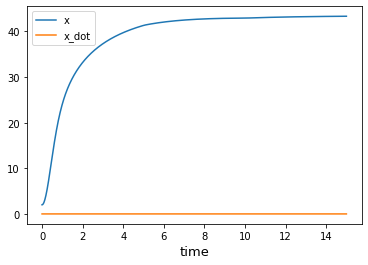

In [36]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot'])

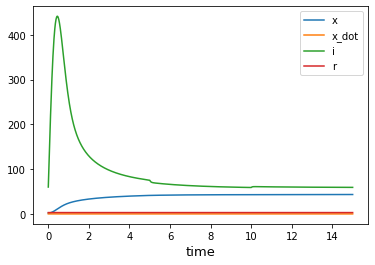

In [30]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.plot(t,i)
plt.plot(t,r)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot', 'i', 'r'])

This is clearly not the correct behavior for the system based on the input, and also by observation. The position cannot be changing without the velocity never being nonzero, but whenever the initial condition is changed for velocity to anything other than zero the plot rapidly diverges for velocity and produces huge values. The coupling must be incorrect somewhere internally.

In [38]:
##3 

##---secomd nonlinear simulation---##
x0 = [2, 0, 60, 3]
x_bar = 15
print("x_bar=", x_bar)
x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)

x_vec = odeint(nonlin_odes, x0, t,)

x_bar= 15
r_bar= 3.039528321078427
x_dot_bar= 0
i_bar= 59.63554565955874
v_bar= 596.3554565955875


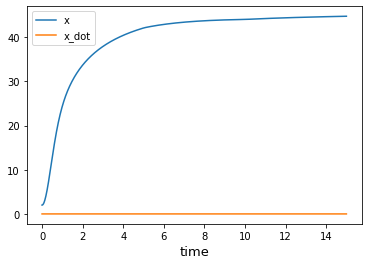

In [39]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot'])

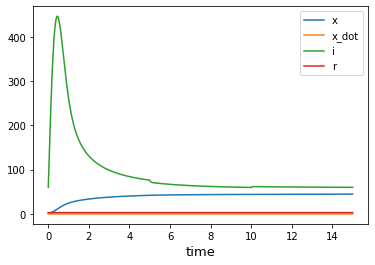

In [40]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.plot(t,i)
plt.plot(t,r)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot', 'i', 'r'])

The behavior does not seem to change based on the change in the trim point, indicating a decoupling or perhaps a magnitude that is incorrect. I am not sure why the relationship in the system will not update

In [41]:
##3 

##---secomd nonlinear simulation---##
x0 = [2, 0, 60, 3]
x_bar = 30
print("x_bar=", x_bar)
x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)

x_vec = odeint(nonlin_odes, x0, t,)

x_bar= 30
r_bar= 3.0785491435537757
x_dot_bar= 0
i_bar= 60.40113419652508
v_bar= 604.0113419652508


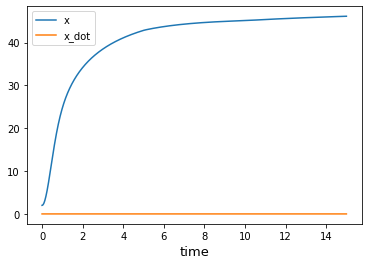

In [42]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot'])

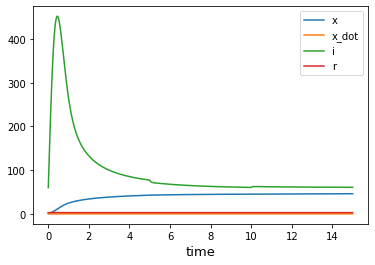

In [43]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.plot(t,i)
plt.plot(t,r)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot', 'i', 'r'])

The same behavior as the two previous seems to occur.

# Part 4 Simulate the Linearized System

In [55]:
##5 

##---first linear simulation---##
x0 = np.array([5, 0, 60, 3])

#print(x0.shape)
x_bar = 0

x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)
A = JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k)
#print(type(A))
#print(A)
#print(np.linalg.eig(A))
B = JacB(L, k)

Bu = v_bar*B
x_vec = odeint(lin_odes, x0, t, (A, B, v_bar))

r_bar= 3.0
x_dot_bar= 0
i_bar= 58.86
v_bar= 588.6


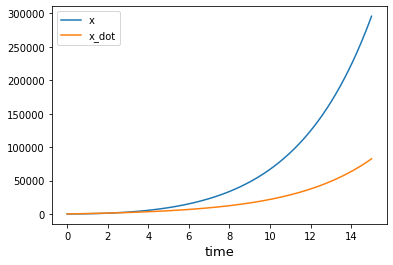

In [56]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot'])

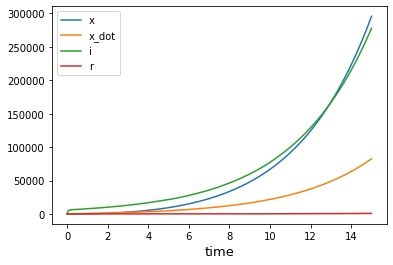

In [57]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.plot(t,i)
plt.plot(t,r)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot', 'i', 'r'])

I know for certain that this is not the correct data for the ODE but I cannot seem to make the result work out from what I am giving it. The linear data in particular seems very unstable and divergent and I have checked every component of the jacobian by hand so I know that that is not the issue. The doublet simulation may be at fault, but again I do not know how that would be the case. There is nothing indicating issue in the ODEs themselves, so the issue may be in the programming itslef. every value is divergent except for the radius.

In [58]:
##5 

##---second linear simulation---##
x0 = np.array([5, 0, 60, 3])

#print(x0.shape)
x_bar = 15

x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)
A = JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k)
#print(type(A))
#print(A)
#print(np.linalg.eig(A))
B = JacB(L, k)

Bu = v_bar*B
x_vec = odeint(lin_odes, x0, t, (A, B, v_bar))

r_bar= 3.039528321078427
x_dot_bar= 0
i_bar= 59.63554565955874
v_bar= 596.3554565955875


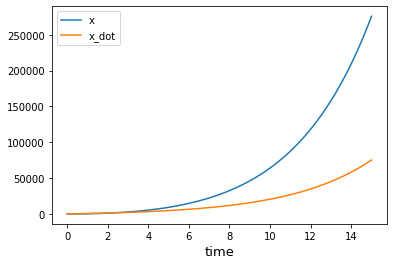

In [59]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot'])

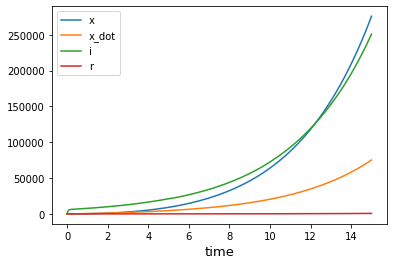

In [60]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.plot(t,i)
plt.plot(t,r)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot', 'i', 'r'])

Again the same behavior seems to occur no matter what, even regardless of the initial conditions on x0, though x seems to diverge less rapidly.

In [61]:
##5 

##---second linear simulation---##
x0 = np.array([5, 0, 60, 3])

#print(x0.shape)
x_bar = 30

x_dot_bar, i_bar, r_bar, v_bar = trim(x_bar, m, g, W, R_0, del_R, del_c, r0, k)
A = JacA(x_bar, x_dot_bar, i_bar, r_bar, I_m, m, g, W, R_0, del_R, del_c, k)
#print(type(A))
#print(A)
#print(np.linalg.eig(A))
B = JacB(L, k)

Bu = v_bar*B
x_vec = odeint(lin_odes, x0, t, (A, B, v_bar))

r_bar= 3.0785491435537757
x_dot_bar= 0
i_bar= 60.40113419652508
v_bar= 604.0113419652508


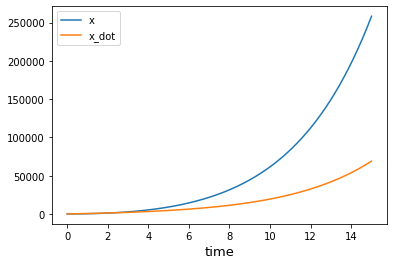

In [62]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot'])

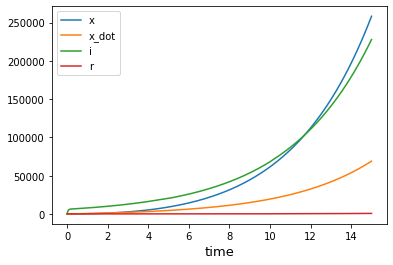

In [63]:
x = x_vec[:,0]
x_dot = x_vec[:,1]
i = x_vec[:,2]
r = x_vec[:,3]
plt.plot(t, x)
plt.plot(t,x_dot)
plt.plot(t,i)
plt.plot(t,r)
plt.xlabel("time",fontsize='13')
plt.legend(['x', 'x_dot', 'i', 'r'])

The behavior is unaffected by any of the trim points.